# Electrochemical PM10 sensor data preprocessing

- Pollutant: Particulate Matter
- Sensor: Alphasense OPC-N3

## Constants

### Sensors IDs

### API Constants

In [28]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
RAW_DATA_DIR = "data/raw-data-monit-fix-2022-2023-Diamante/"
RAW_FILE_NAME = "OPC_PM10.CSV"

SENSOR_FILE_DIR = 'data/input/'
SENSOR_NAME = 'alpha_pm_10_conc'
SENSOR_FILE_NAME = SENSOR_NAME + 'web_dataframe.csv'

### Sensor Constants

In [29]:
lower_limit=0.0
upper_limit=2e3
sampling_period = 15 * 60

# Alphasense PM10 Sensor Data

In [30]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_BR')

'pt_BR'

In [31]:
from GetSensorDataService import GetSensorDataService

get_sensor_data_service = GetSensorDataService(HOST, PORT)
sensor_data = get_sensor_data_service.get_data_from_file(RAW_DATA_DIR+RAW_FILE_NAME, sensor_name=SENSOR_NAME)
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/GetSensorDataService.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,-9999.99,2022-11-21 10:44:06
1,-28.456899,-48.972999,-9999.99,2022-11-21 10:59:51
2,-28.456899,-48.972999,-9999.99,2022-11-21 11:15:41
3,-28.456899,-48.972999,-9999.99,2022-11-21 11:31:25
4,-28.456899,-48.972999,-9999.99,2022-11-21 11:47:05


## Upload Data from File

In [32]:
import pandas as pd

df = pd.read_csv(SENSOR_FILE_DIR + SENSOR_FILE_NAME)
df.head()

,Unnamed: 0,latitude,longitude,measuring,DateTime
0,0,-28.456899,-48.972999,-9999.99,2022-11-21 10:44:06
1,1,-28.456899,-48.972999,-9999.99,2022-11-21 10:59:51
2,2,-28.456899,-48.972999,-9999.99,2022-11-21 11:15:41
3,3,-28.456899,-48.972999,-9999.99,2022-11-21 11:31:25
4,4,-28.456899,-48.972999,-9999.99,2022-11-21 11:47:05


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [33]:
# Remove the first column with the indexes and save data into web dataframe
web_dataframe = df.drop(df.columns[0], axis='columns')
web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = web_dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_4959/166902210.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring
DateTime,,,
2022-11-21 10:30:00,-28.456899,-48.972999,-9999.99
2022-11-21 10:45:00,-28.456899,-48.972999,-9999.99
2022-11-21 11:00:00,NaN,NaN,NaN
2022-11-21 11:15:00,-28.456899,-48.972999,-9999.99
2022-11-21 11:30:00,-28.456899,-48.972999,-9999.99
...,...,...,...
2023-04-21 20:30:00,-28.456899,-48.972999,-9999.99
2023-04-21 20:45:00,-28.456899,-48.972999,-9999.99
2023-04-21 21:00:00,-28.456899,-48.972999,-9999.99


### Plot raw data

<Axes: xlabel='DateTime'>

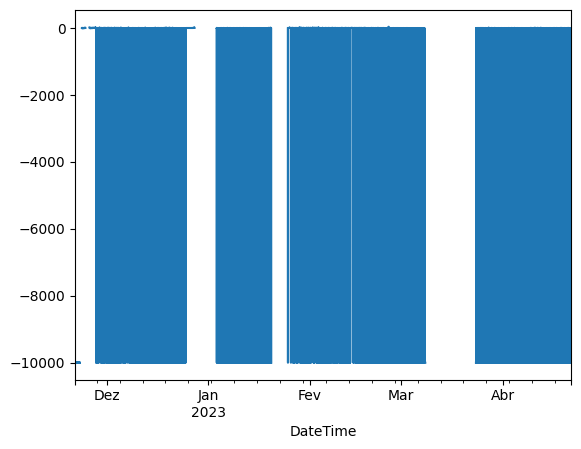

In [34]:
sensor_dataframe['measuring'].plot()

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

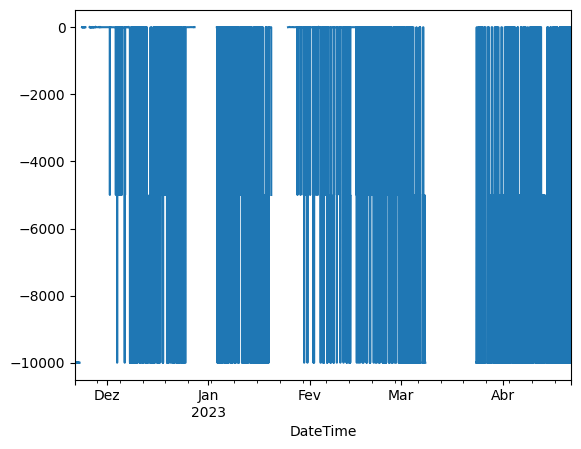

In [35]:
sensor_dataframe['raw measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['measuring'].rolling(window=4).median()
sensor_dataframe['Hour'] = sensor_dataframe.index.hour
sensor_dataframe['measuring'].plot()

## Tag data
Apply tags to the data according to the quality control processes described above

In [36]:
sensor_dataframe['Tag'] = 'VALID'

#### Tag values that are missing, are greater than sensor span or are lower than sensor resolution

The upper limit was too high that affected the graph resolution, therefore it is not plotted

<Axes: xlabel='DateTime'>

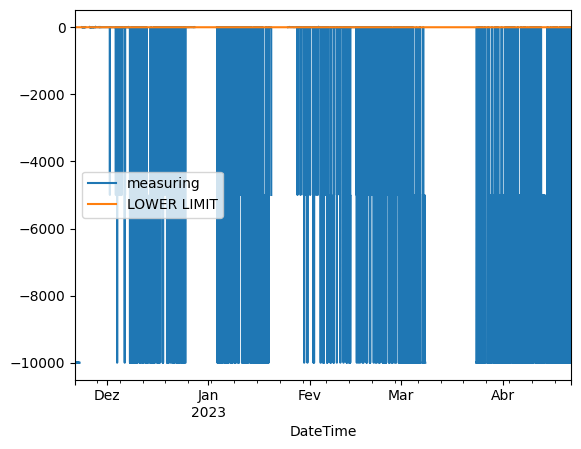

In [37]:
sensor_dataframe['UPPER LIMIT'] = upper_limit
sensor_dataframe['LOWER LIMIT'] = lower_limit
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'LOWER LIMIT']].resample('15T').mean().plot()

In [38]:
import numpy as np
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_sensor_limits(value, tag, lower_limit, upper_limit):
 if (tag != 'VALID'): return tag
 return sensor_analysis.get_tags_from_series(value=value,
                                             lower_limit=lower_limit,
                                             upper_limit=upper_limit)

sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Tag']]
                                        .apply(lambda df: tag_by_sensor_limits(value=df[0], tag=df[1],
                                                                              lower_limit=lower_limit,
                                                                              upper_limit=upper_limit),
                                                axis=1))

#### Plot valid data after removing samples bellow lower limit

Text(0, 0.5, 'Concentração (ug/m³)')

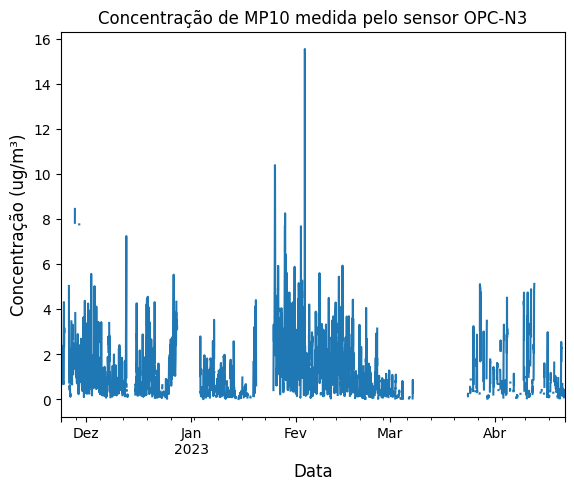

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*5,5))
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de MP10').resample('15T').mean().plot()
plt.title('Concentração de MP10 medida pelo sensor OPC-N3')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ug/m\N{SUPERSCRIPT THREE})', fontsize=12)

## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

In [40]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag'])

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

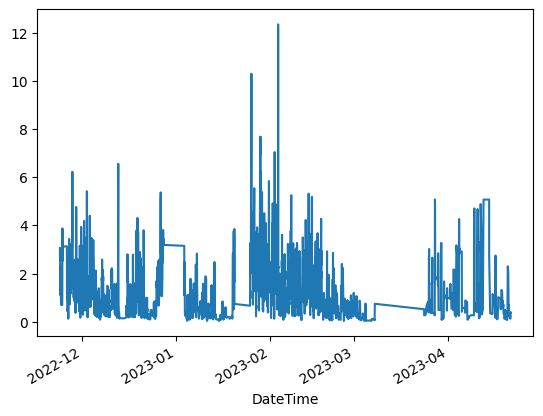

In [41]:
valid_dataframe['raw measuring'] = valid_dataframe['measuring']
valid_dataframe['measuring'] = valid_dataframe['measuring'].rolling(window=4).median()
valid_dataframe['measuring'].plot()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


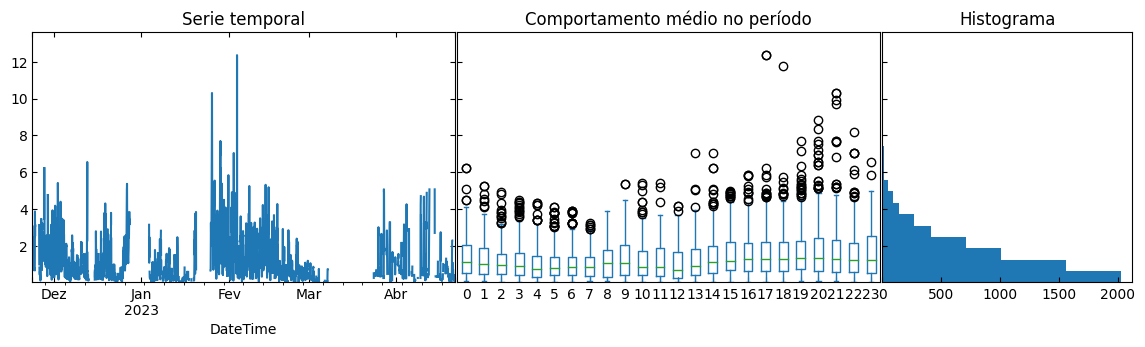

In [42]:
valid_dataframe = valid_dataframe.resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

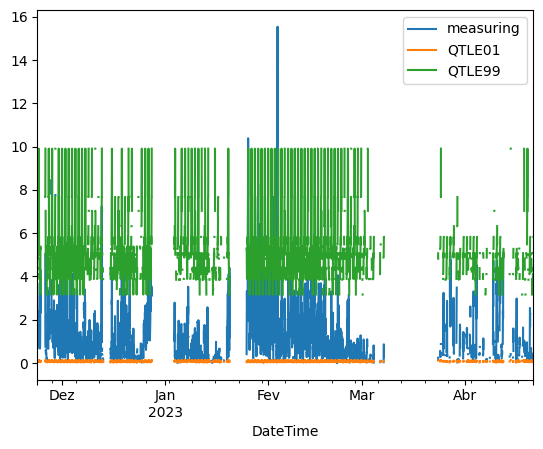

In [43]:
import numpy as np

global_qtle_01 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

### Tag data according to quantiles

In [44]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,6481,44.570525
LTLL,1759,12.09683
GTUL,0,0.0
BADSPIKE,0,0.0
VALID,6098,41.936593
LTQTLE01,117,0.804621
GTQTLE99,86,0.591431
TOTAL,14541,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

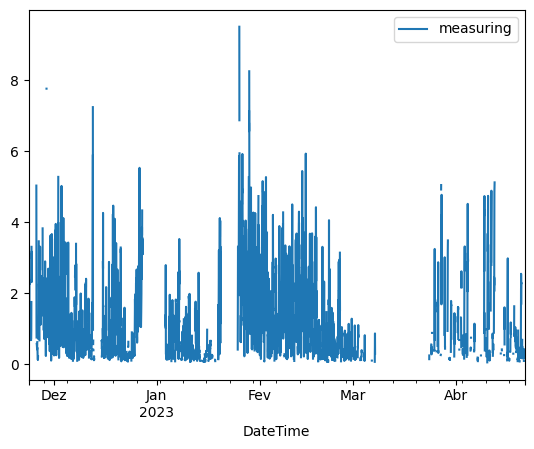

In [45]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

#### Analyse data after removing quantiles

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


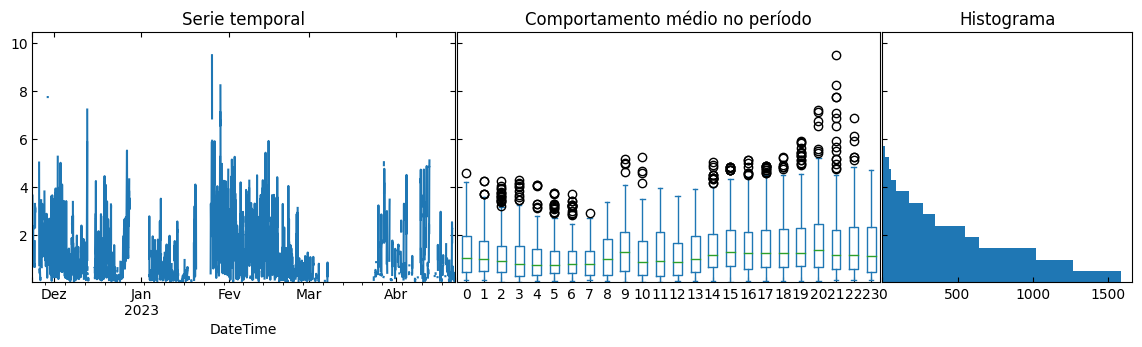

In [46]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Analyse data derivatives

Analyse the derivatives of the data for removing abrupt changes in the data (BADSPIKE)

#### Tag values with derivatives faster than sensor response time
The value of 100 ug/m3 was selected based on the maximum derivative found in the reference data. The maximum derivative (with measuring period of 1 hour) found was 150 ug/m3 ppb. Therefore, a maximum of 100 ug/m3 was considered appropriate for a 15 mins period.

<Axes: xlabel='DateTime'>

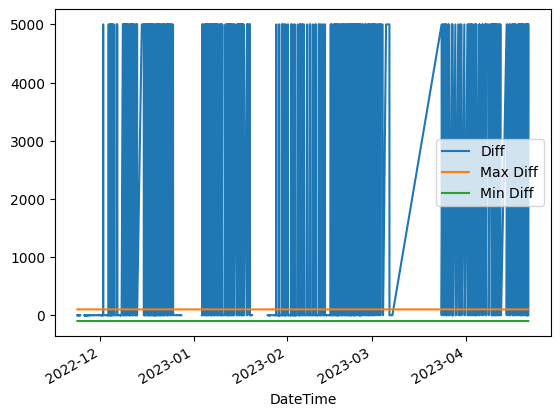

In [47]:
max_diff_value = 100
sensor_dataframe['Diff'] = sensor_dataframe['measuring'].resample('15T').mean().diff()
sensor_dataframe['Max Diff'] = max_diff_value
sensor_dataframe['Min Diff'] = -max_diff_value
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'Max Diff', 'Min Diff']].plot()

In [48]:
import numpy as np

def tag_data_with_derivatives(tagged_df, max_diff_value):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'Max Diff']]
                           .apply(lambda df: tag_data_with_derivatives(tagged_df=df, max_diff_value=df[2]),
                                   axis=1))

tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,6481,44.570525
LTLL,1759,12.09683
GTUL,0,0.0
STABILIZING,0,0.0
BADSPIKE,427,2.936524
VALID,5671,39.000069
LTQTLE01,117,0.804621
GTQTLE99,86,0.591431
REBASE,0,0.0
TOTAL,14541,100.0


<Axes: xlabel='DateTime'>

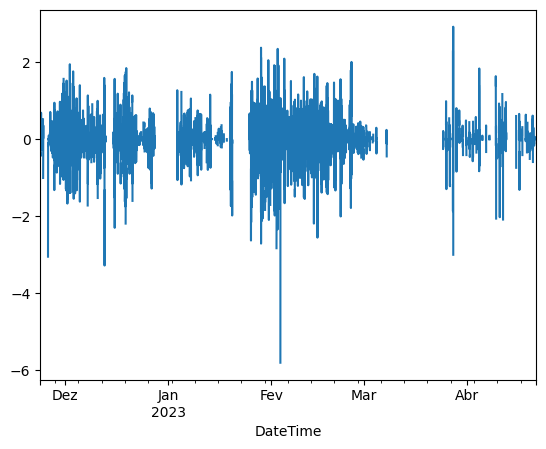

In [49]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'].resample('15T').mean().plot()

#### Plot data derivatives vs data

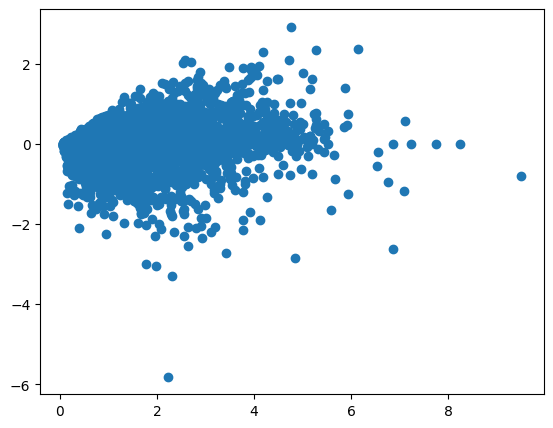

In [50]:
import matplotlib.pyplot as plt

valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']
fig = plt.figure(figsize=(1.3*5,5))
plt.scatter(valid_dataframe['measuring'], valid_dataframe['Diff'])

#### Remove sample with derivative < -4 and value 8

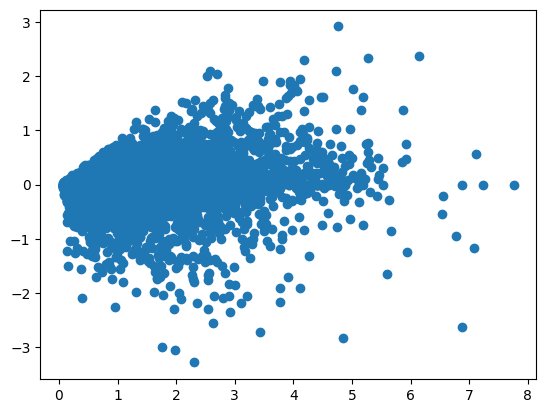

In [51]:
sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Diff', 'Tag']]
                           .apply(lambda df: 'BADSPIKE' if df[2] == 'VALID' and (df[0] > 8 or df[1] <= -4) else df[2], axis=1))
plt.scatter(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'],
            sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'])
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']

#### Data Tag contabilization

In [52]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,6481,44.570525
LTLL,1759,12.09683
GTUL,0,0.0
STABILIZING,0,0.0
BADSPIKE,430,2.957156
VALID,5668,38.979437
LTQTLE01,117,0.804621
GTQTLE99,86,0.591431
REBASE,0,0.0
TOTAL,14541,100.0


#### Plot valid data

Text(0, 0.5, 'Concentração (ug/m³)')

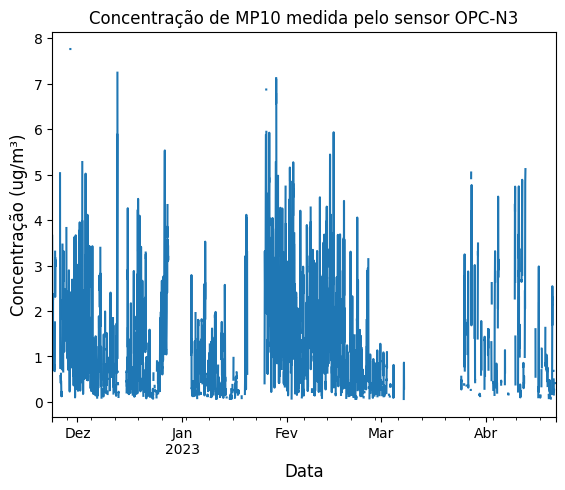

In [53]:
fig, ax = plt.subplots(figsize=(1.3*5,5))
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de MP10').resample('15T').mean().plot()
plt.title('Concentração de MP10 medida pelo sensor OPC-N3')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ug/m\N{SUPERSCRIPT THREE})', fontsize=12)

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


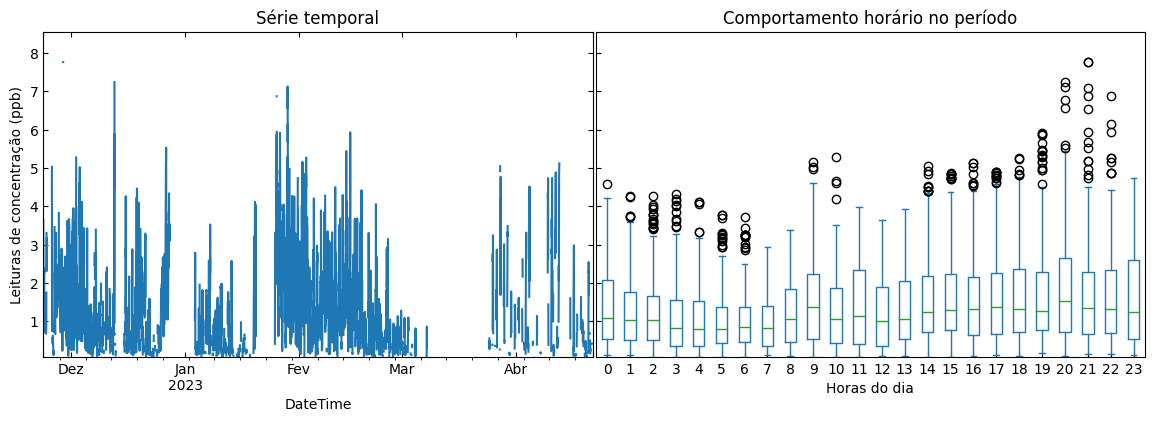

In [54]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box(df=valid_dataframe)

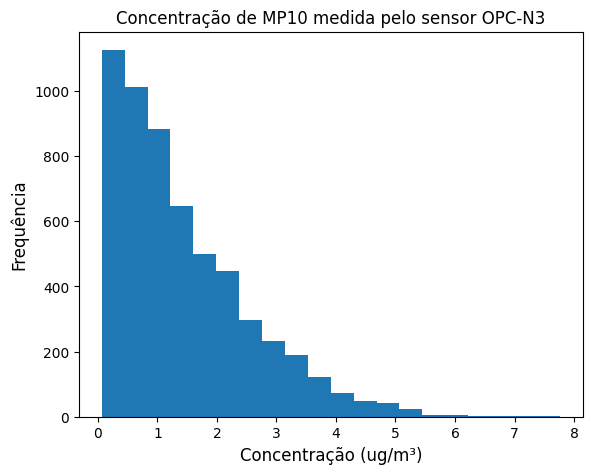

In [55]:
fig, ax = plt.subplots(figsize=(1.3*5,5))
(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de MP10')
 .resample('15T').mean().hist(bins=20))
plt.title('Concentração de MP10 medida pelo sensor OPC-N3')
ax.set_xlabel('Concentração (ug/m\N{SUPERSCRIPT THREE})', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(False)

<Axes: xlabel='DateTime'>

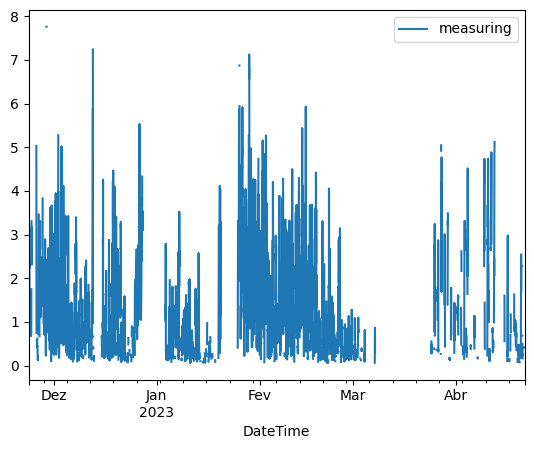

In [56]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


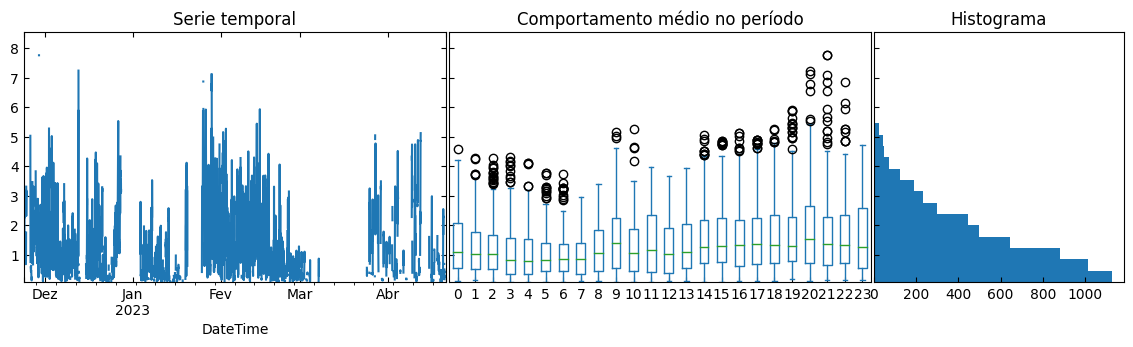

In [57]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

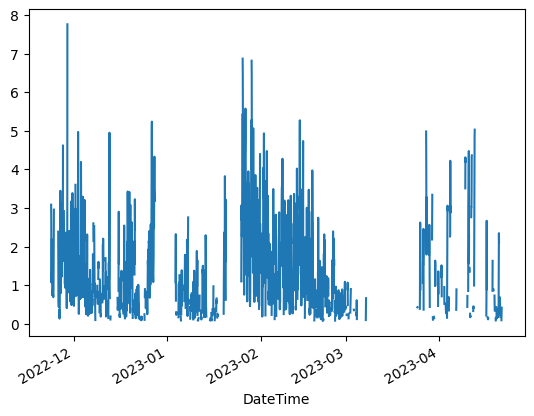

In [58]:
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

Text(0, 0.5, 'Concentração (ug/m³)')

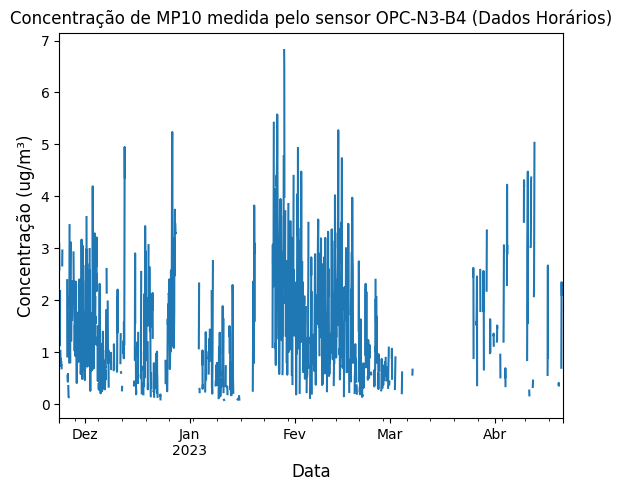

In [59]:
original_freq = sensor_dataframe.index.freq
resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                    .map(lambda c:
                                        c / (pd.Timedelta("1 hour") / original_freq) * 100))
resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))

fig, ax = plt.subplots(figsize=(1.3*5,5))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de MP10').resample('1H').mean().plot()
plt.title('Concentração de MP10 medida pelo sensor OPC-N3-B4 (Dados Horários)')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ug/m\N{SUPERSCRIPT THREE})', fontsize=12)

#### Valid data contabilization

In [60]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,2269,63.3445
VALID,1313,36.6555
TOTAL,3582,100.0


## Analyse the mean and standard deviation of the resampled data

The color of each data point represents the percentage of valid 15 mins samples found in an hour

#### Plot mean (Y axis) vs. standard deviation (X axis) for valid hourly data colored by valid percentage of valid samples

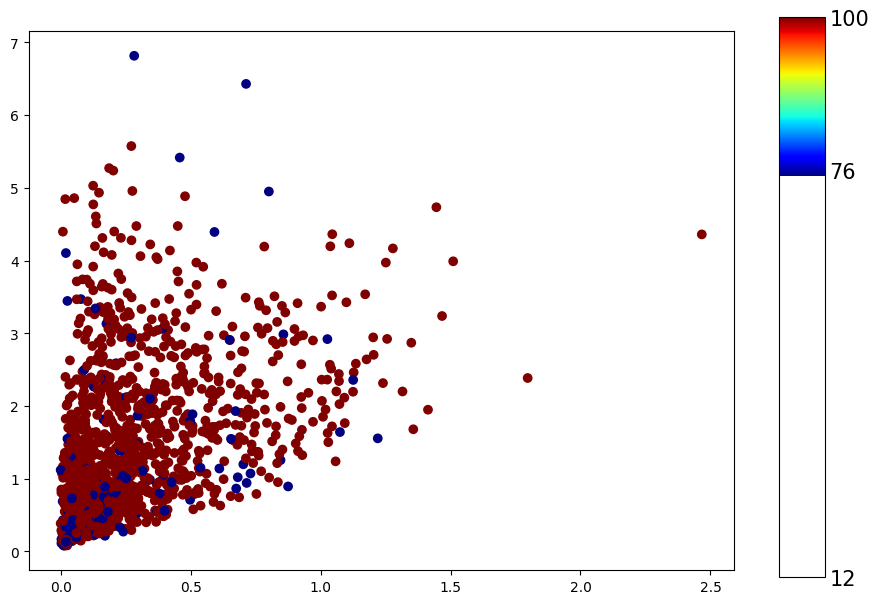

In [61]:
valid_resampled_dataframe = resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']
sensor_analysis.plot_mean_vs_std(valid_resampled_dataframe)

### Plot standard deviation in time colored according to the percentage of valid samples

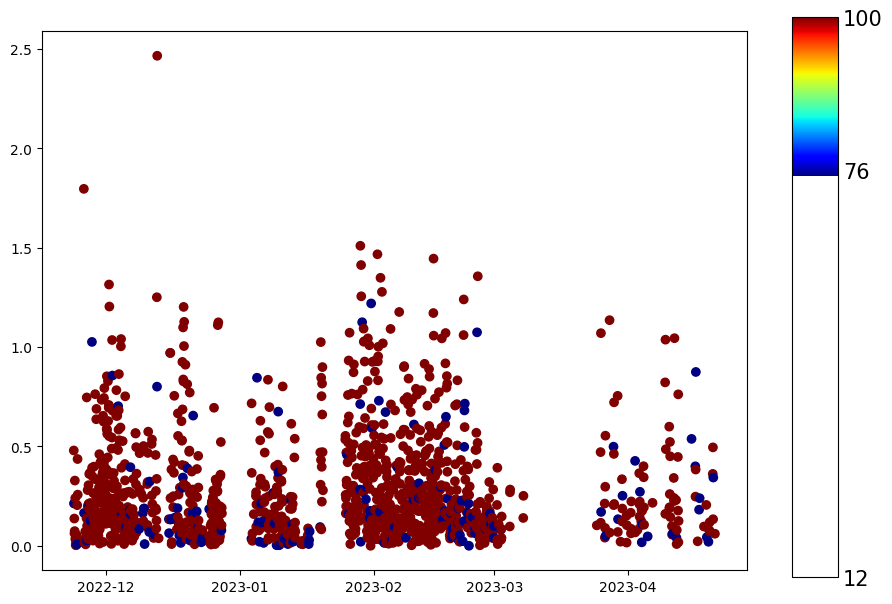

In [62]:
sensor_analysis.plot_std_in_time(valid_resampled_dataframe)

# Save Data

In [63]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_1HR_filename = '_valid_data_1HR.csv'
valid_filename = '_valid_data.csv'
dataframe_filename = '_dataframe.csv'
dataframe_1HR_filename = '_dataframe_1hr.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_1HR_filename
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

dataframe_path_1HR_output = output_directory_path + SENSOR_NAME + dataframe_1HR_filename
dataframe_path_output = output_directory_path + SENSOR_NAME + dataframe_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_1HR_filename
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

processing_dataframe_path_1HR = processing_directory_path + SENSOR_NAME + dataframe_1HR_filename
processing_dataframe_path = processing_directory_path + SENSOR_NAME + dataframe_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].to_csv(valid_file_path_output)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].to_csv(valid_1HR_file_path_output)
sensor_dataframe.to_csv(dataframe_path_output)
resampled_dataframe.to_csv(dataframe_path_1HR_output)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].to_csv(valid_processing_file_path)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].to_csv(valid_processing_1HR_file_path)
sensor_dataframe.to_csv(processing_dataframe_path)
resampled_dataframe.to_csv(processing_dataframe_path_1HR)